In this project I analyze the Ames Housing dataset compiled by Dean De Cock. This is a massive dataset with about eighty features and the goal is to apply advanced, scalable feature engineering and modeling techniques to predict house prices.

#### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

#### Importing data and Exploratory Data Analysis

In [2]:
house_df = pd.read_csv('house_train.csv')

In [3]:
# Checking feature details for train and test datasets
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#Checking for null values by features in data
house_df.isnull().sum().to_frame('sum_null').query('sum_null >0')

,sum_null
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


We have multiple features with a huge chunk of values missing, some as high as 90% from plain observation. We'll handle the missing values in Feature Engineering section and plot some additional graphs once the missing values are imputed.

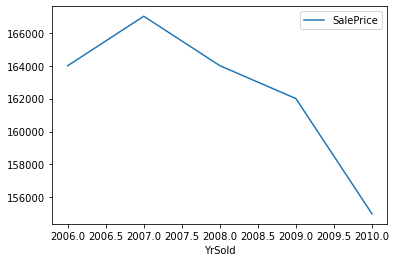

In [5]:
# Plotting SalePrice v YrSold
house_df[['SalePrice', 'YrSold']].groupby('YrSold').median().plot()

This plot shows reduced prices over time - which is counterintuitive to what we know from our real world experience. We need to dig more into additional temporal (year) data.

We have four temporal features: 'YearBuilt', 'YearRemodd', 'GarageYrBlt', 'YrSold'
Let's explore these features.

In [6]:
# Finding unique values of the temporal variables
temp_feature = [feat for feat in house_df.columns if 'Yr' in feat or 'Year' in feat]  # creating a list of temporal features

for x in temp_feature:        # Printing the number of unique labels within the features
  print(x, ':', len(house_df[x].unique()),'labels')

YearBuilt : 112 labels
YearRemodAdd : 61 labels
GarageYrBlt : 98 labels
YrSold : 5 labels


In [7]:
# Printing the unique values
for x in temp_feature:
    print(x,house_df[x].unique())

YearBuilt [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]
YearRemodAdd [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]
GarageYrBlt [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006.

We see that the YrSold feature is concentrated heavily across only 5 years: 06, 07, 08, 09, 10. While every other temporal feature is spread across the 20th century, some going as far back as 19th century. We can make an assumption that the older the house, last remodeling or building of garage, the lower the price. This can be of course offset by outliers that extremely old buildings may have historic value and therefore a high price, but we can test for this later.

For now, let's visualize this hypothesis by finding the delta between the YrSold and the rest of the temporal variables and visualizing this in a simple scatter plot.

In [8]:
vizdata = house_df.copy()  # creating a copy simply for visualizations

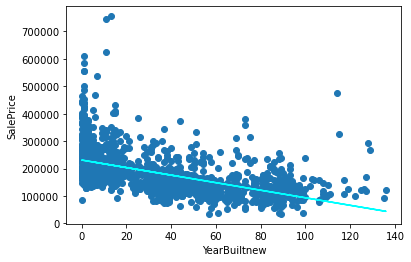

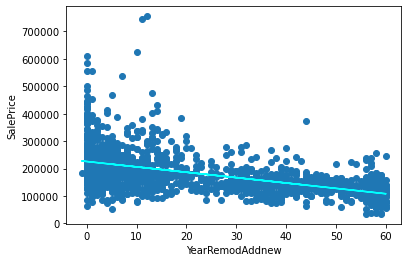

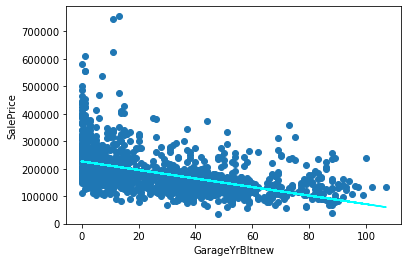

In [9]:
for x in temp_feature:
    if x != 'YrSold':
        vizdata[x+'new'] = vizdata['YrSold']-vizdata[x]
        plt.scatter(vizdata[x+'new'],vizdata['SalePrice'])
        plt.xlabel(x+'new')
        plt.ylabel('SalePrice')
        # filling missing values for completeness
        z = np.polyfit(vizdata[x+'new'].fillna(vizdata[x+'new'].mean()),vizdata['SalePrice'], 1) 
        p = np.poly1d(z)
        plt.plot(vizdata[x+'new'].fillna(vizdata[x+'new'].mean()),p(vizdata[x+'new']), "cyan")
        plt.show()

The above analysis and the trends of the temporal features bolsters our hypothesis that the newer the house/garage/remodeling, the higher the sales price. The method of finding the delta or "age" of the temporal variables will also be used again in Feature Engineering to replace the Year variables with duration/age.

In [10]:
# As we head into the feature engineering section, it's good to create lists of numerical and categorical features

# list of numerical variables
numerical_features = [x for x in house_df.columns if house_df[x].dtypes != 'O']

# list of categorical variables
categorical_features = [x for x in house_df.columns if house_df[x].dtypes == 'O']


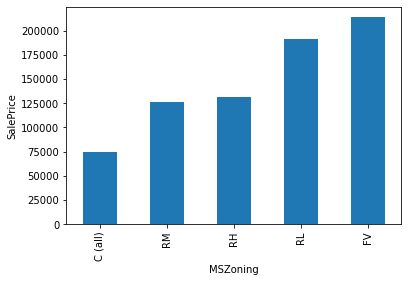

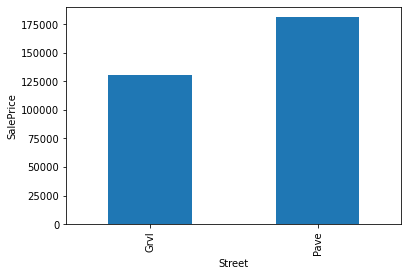

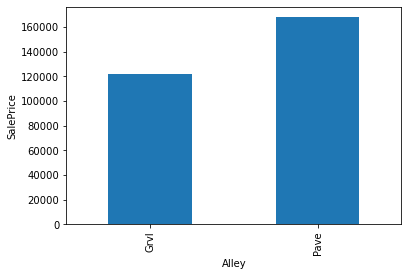

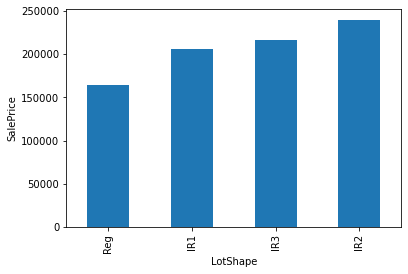

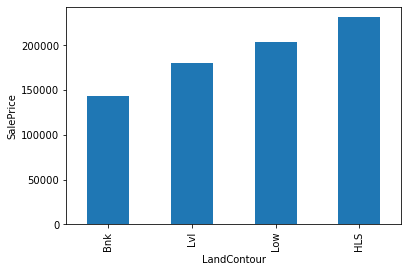

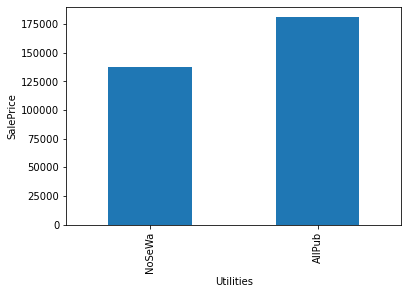

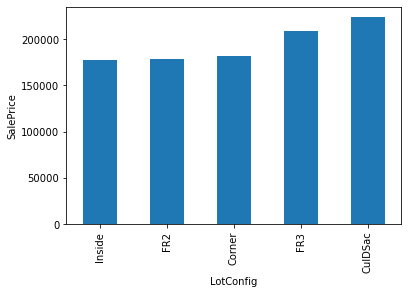

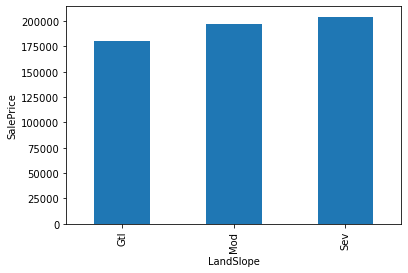

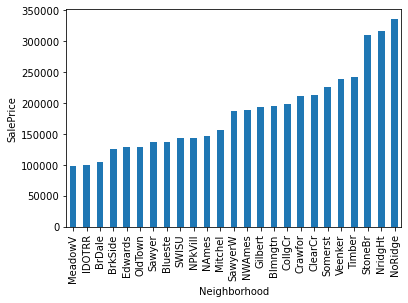

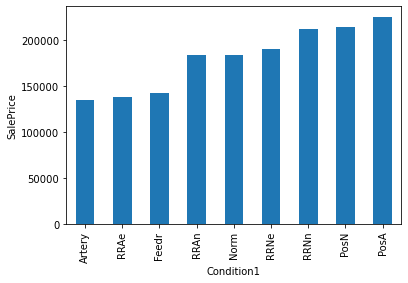

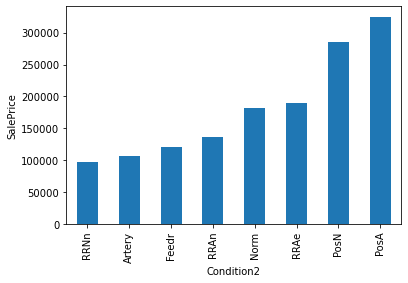

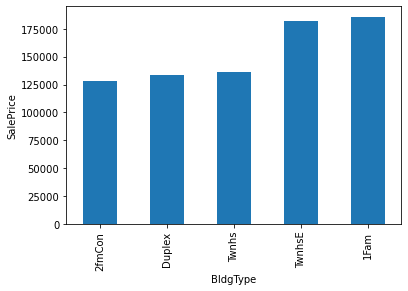

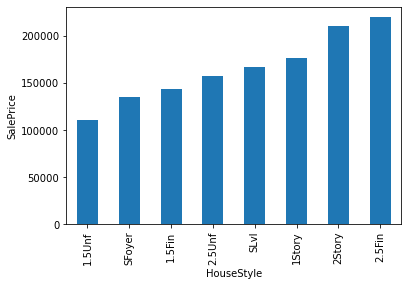

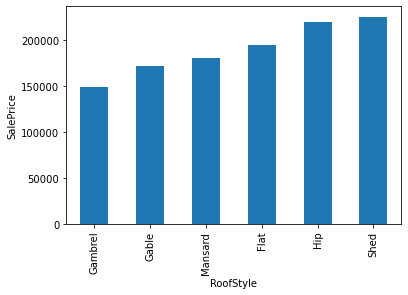

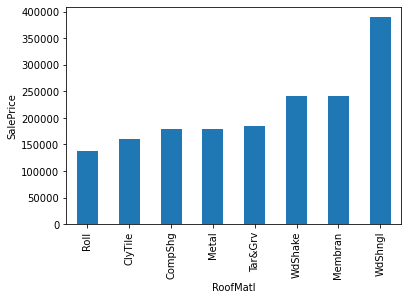

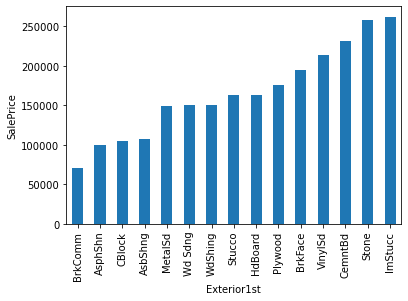

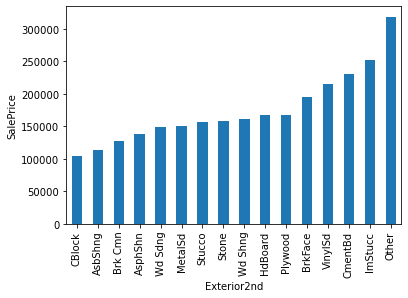

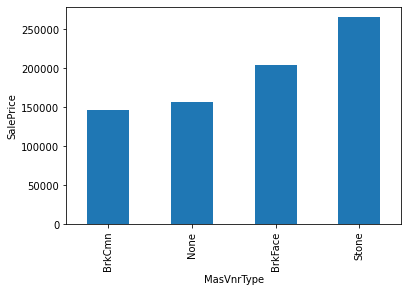

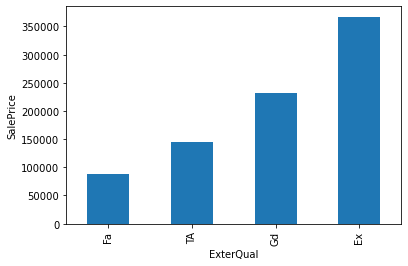

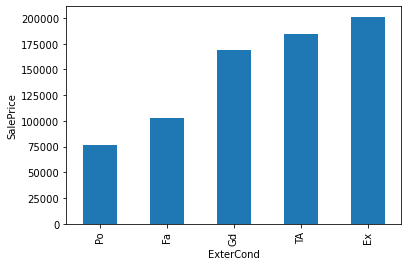

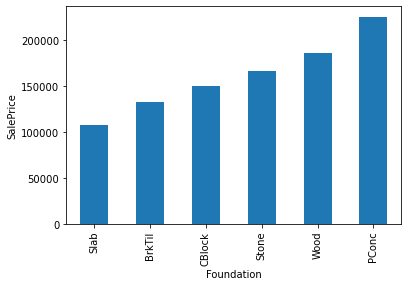

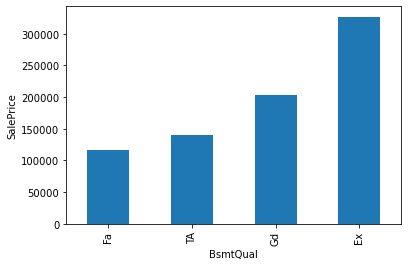

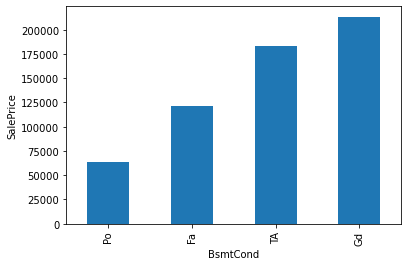

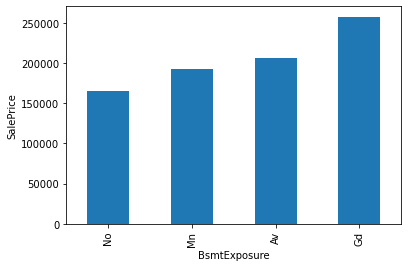

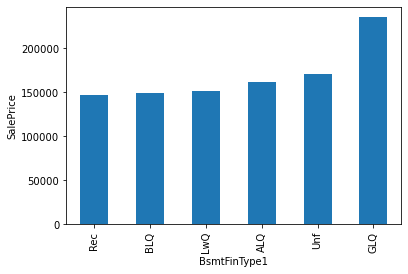

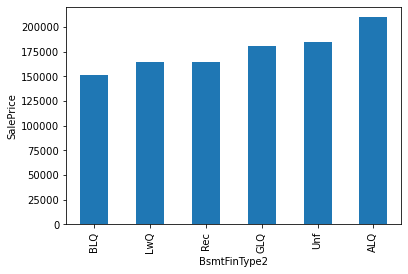

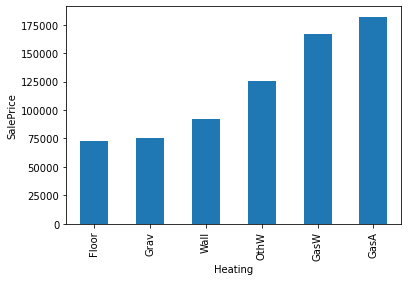

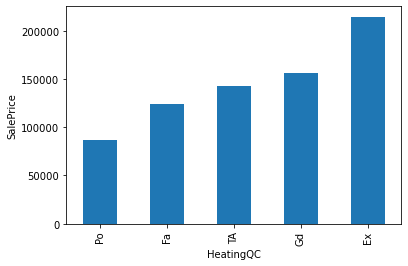

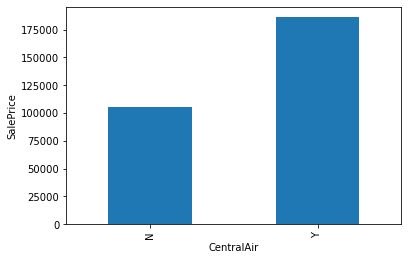

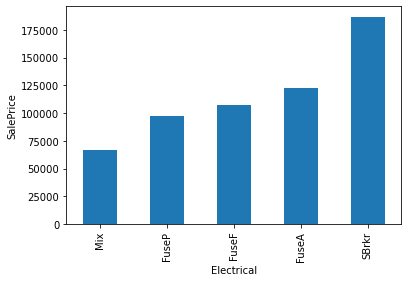

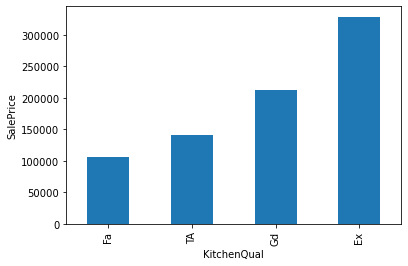

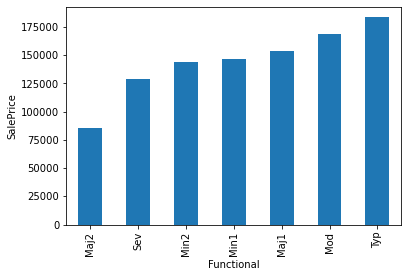

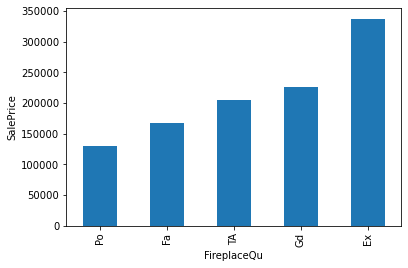

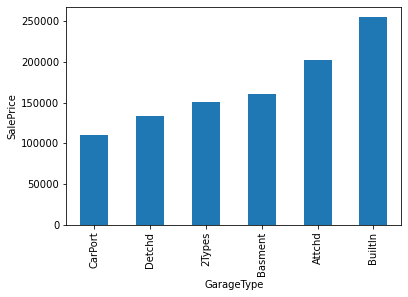

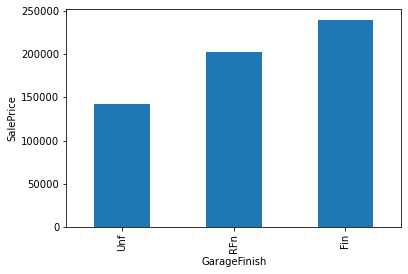

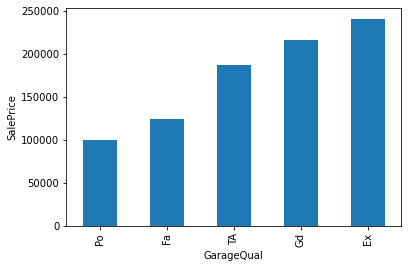

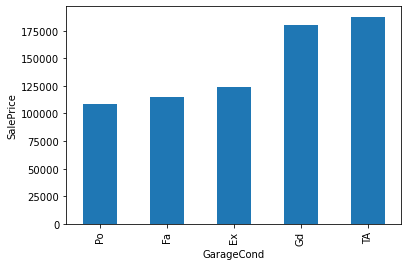

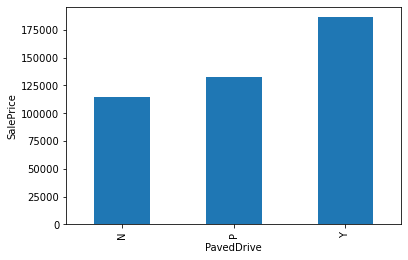

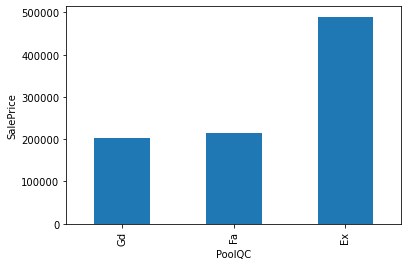

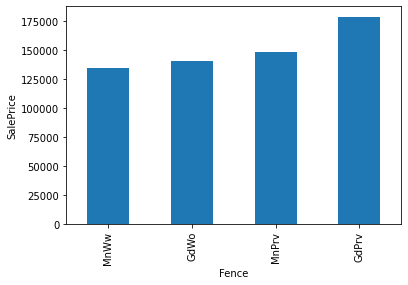

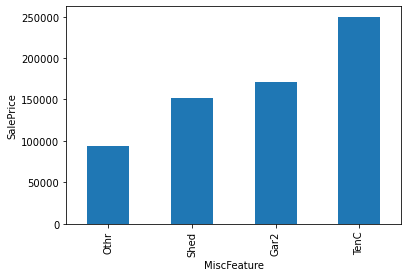

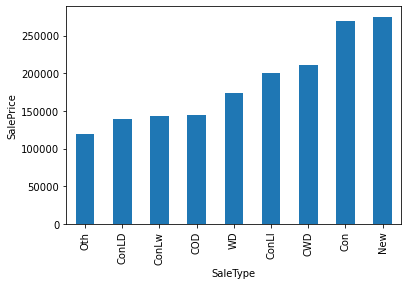

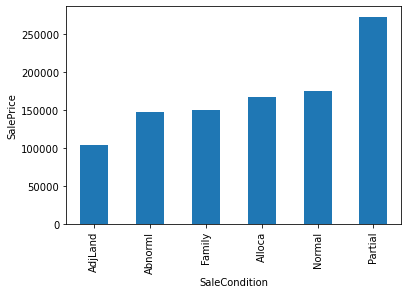

In [11]:
# Visualizing all features individually wrt target variable SalePrice (only for training set)

# Visualizing Categorical Features
for x in categorical_features:
    house_df[[x,'SalePrice']].groupby(x).mean().sort_values('SalePrice',ascending = True).plot.bar(legend = False)
    plt.ylabel('SalePrice')
    plt.show()
    
    

In [12]:
# For visualizing numerical features, it is imperative that we split them into continuous and discreet features

numerical_features_disc = [x for x in numerical_features if len(house_df[x].unique())<30 and x not in temp_feature+['Id']]
numerical_features_disc

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold']

In [13]:
# For continuous numerical features
numerical_features_cont = [x for x in numerical_features if x not in numerical_features_disc+temp_feature+['Id']]
numerical_features_cont

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'SalePrice']

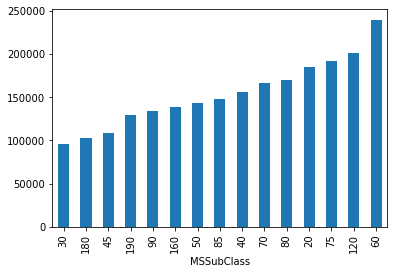

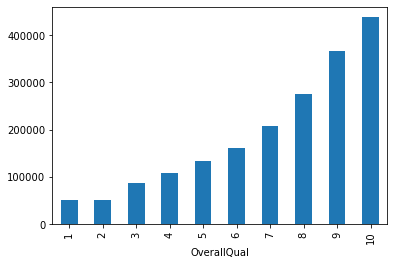

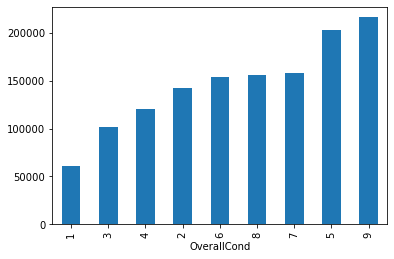

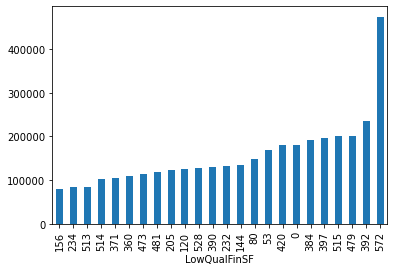

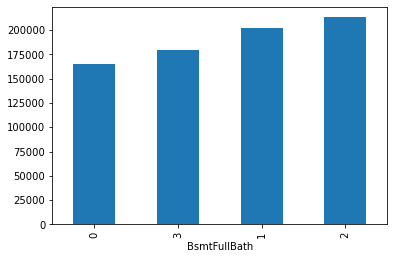

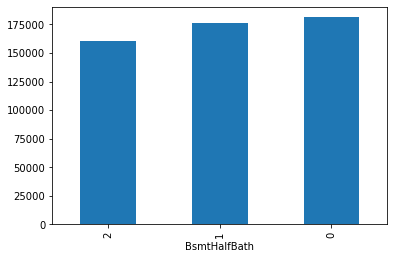

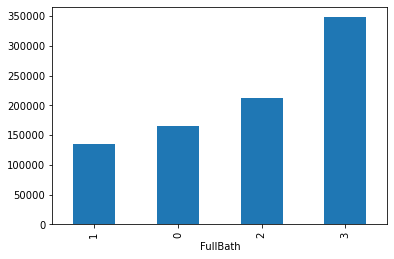

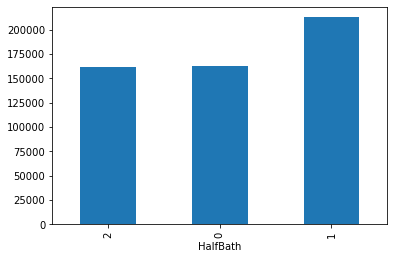

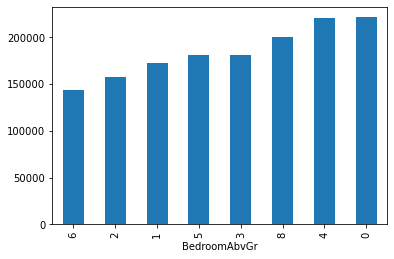

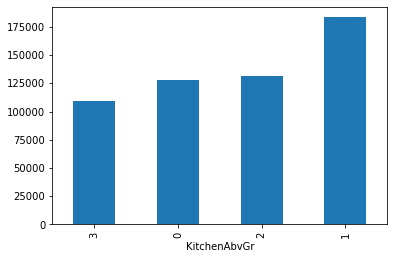

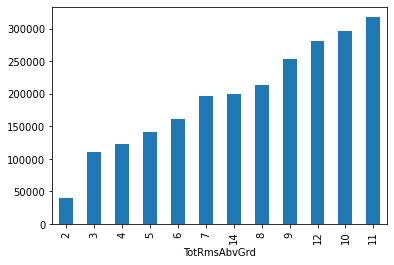

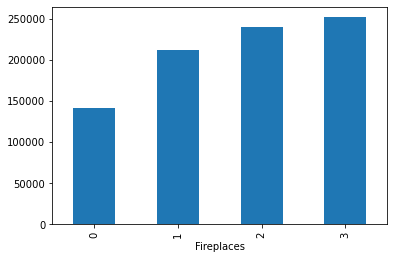

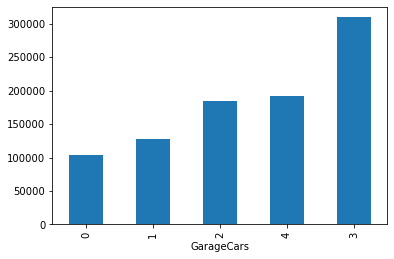

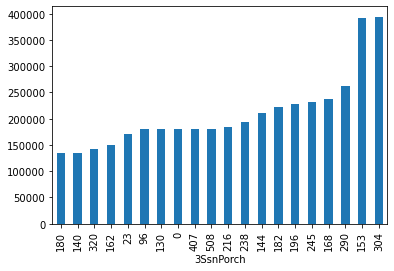

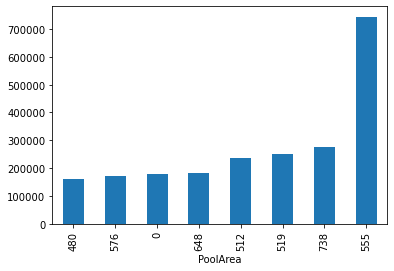

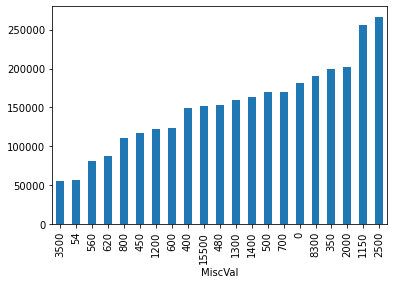

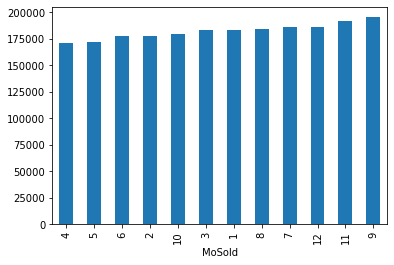

In [14]:
# Visualizing discrete numerical features (for training set only)

for x in numerical_features_disc:
    house_df[[x,'SalePrice']].groupby(x).mean().sort_values('SalePrice').plot.bar(legend = False)
    plt.show()

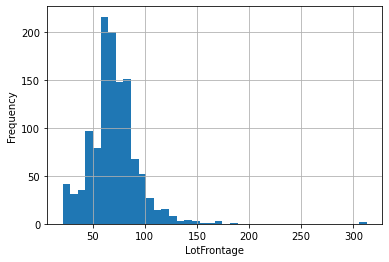

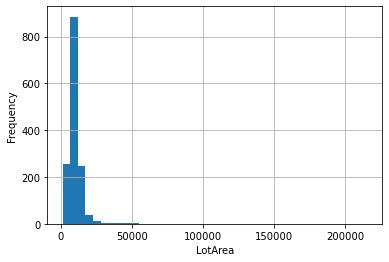

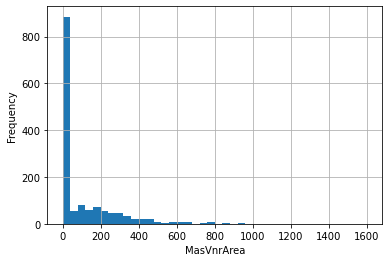

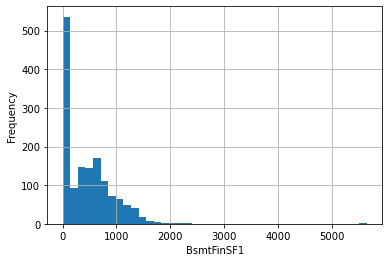

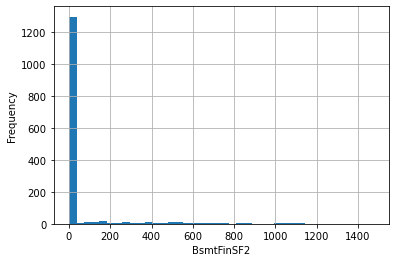

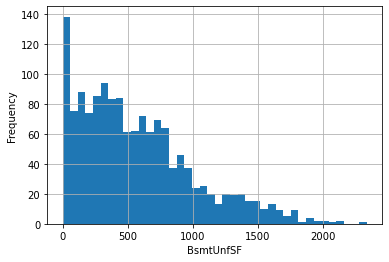

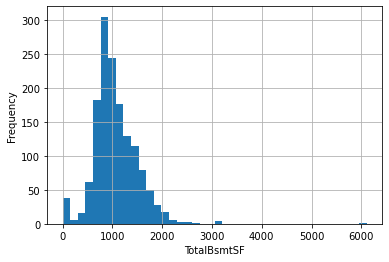

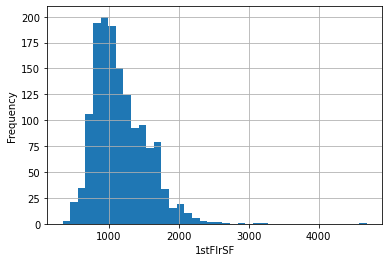

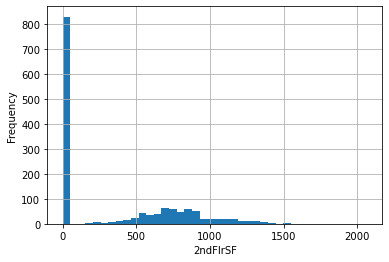

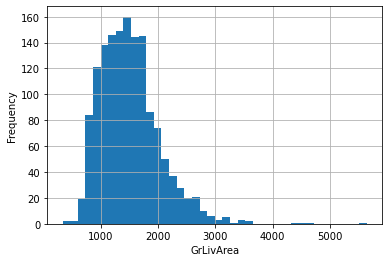

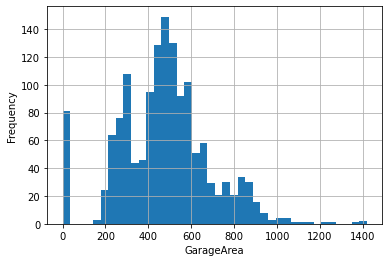

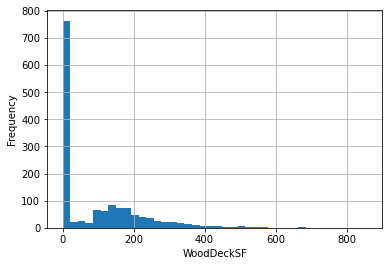

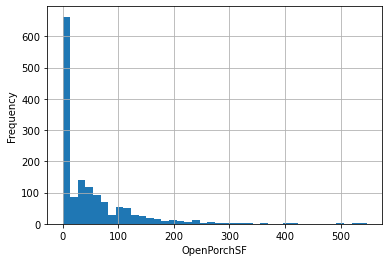

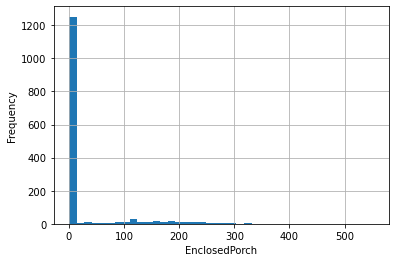

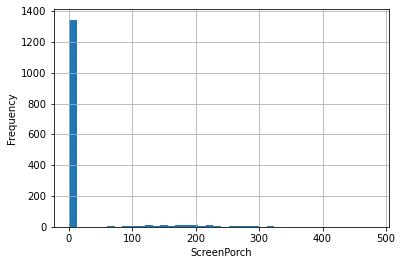

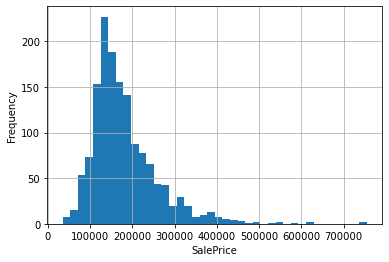

In [15]:
# Visualizing continuous numerical features - univariate graphs (for training set only)

for x in numerical_features_cont:
    house_df[x].plot.hist(legend = False, bins = 40, grid = True)
    plt.xlabel(x)
    plt.show()

From these diagrams we see the continuous features are skewed. Let's try to plot a box plot and see outliers on such skewed features. Then we will log transform the data and visualize again.

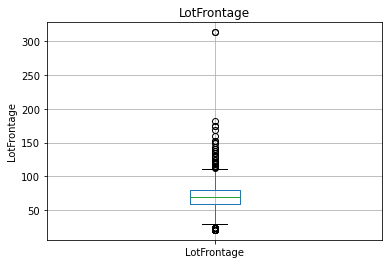

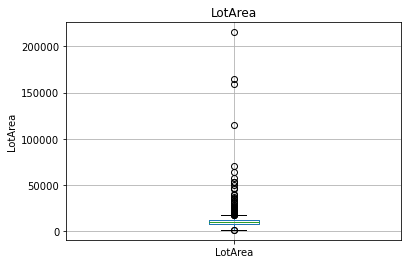

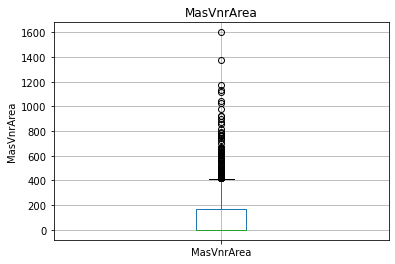

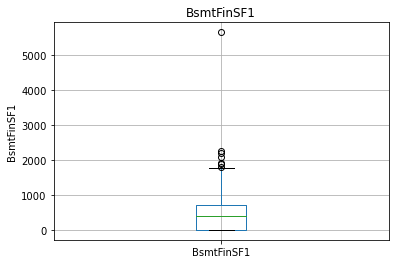

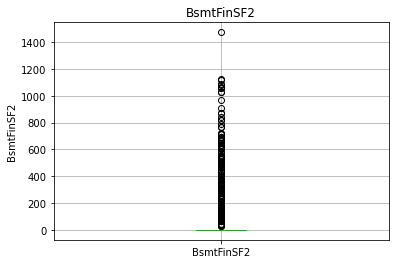

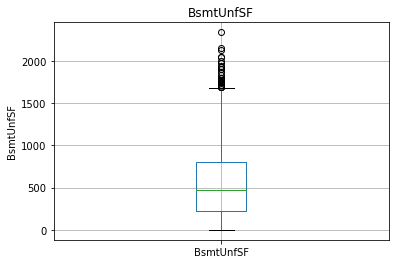

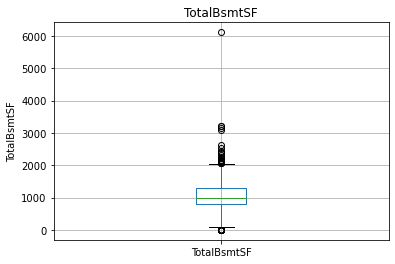

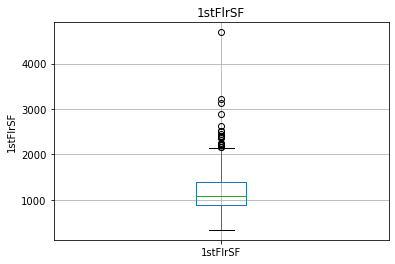

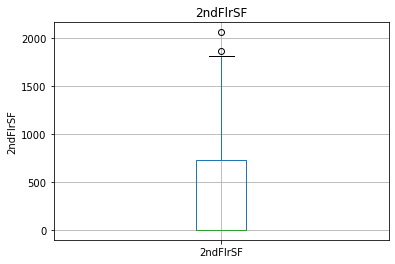

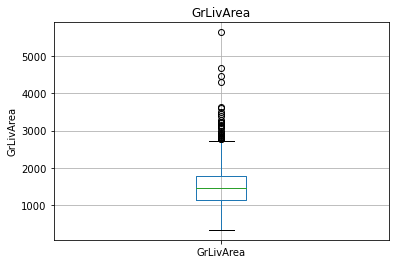

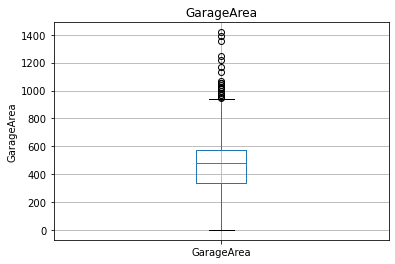

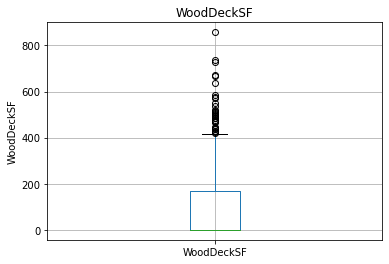

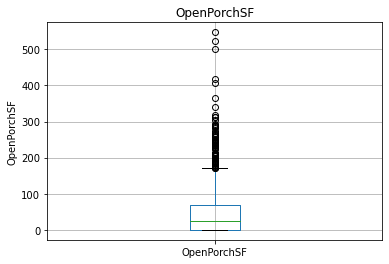

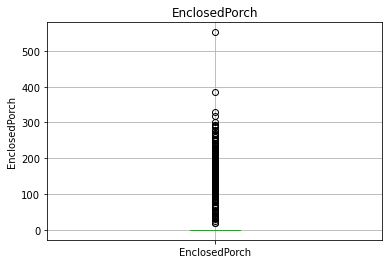

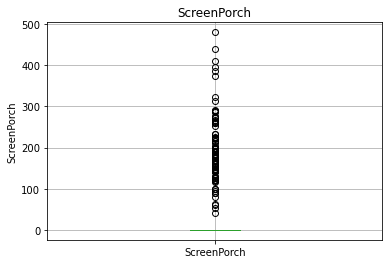

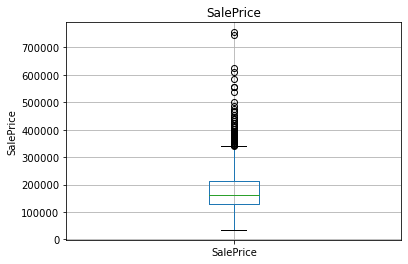

In [16]:
# Box plot without log transform
vizdata2=house_df.copy()
for x in numerical_features_cont:
        vizdata2.boxplot(column=x)
        plt.ylabel(x)
        plt.title(x)
        plt.show()

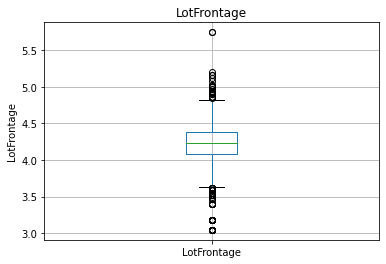

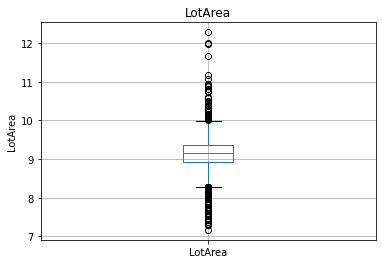

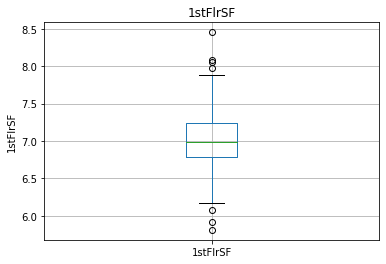

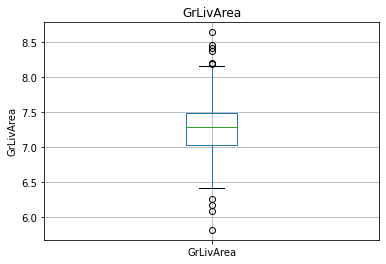

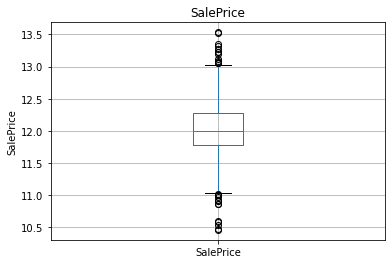

In [17]:
# Box plot with log transform
vizdata2=house_df.copy()
for x in numerical_features_cont:
    if 0 in vizdata2[x].unique():
        pass
    else:
        vizdata2[x] = np.log(vizdata2[x])
        vizdata2.boxplot(column=x)
        plt.ylabel(x)
        plt.title(x)
        plt.show()

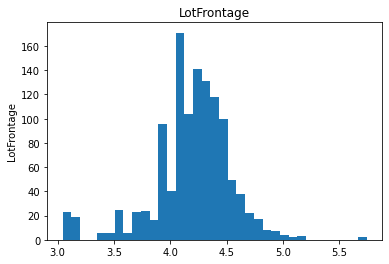

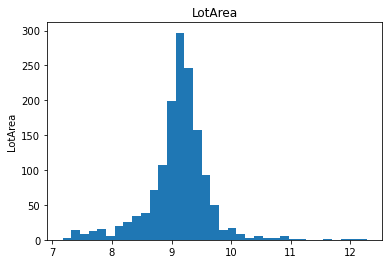

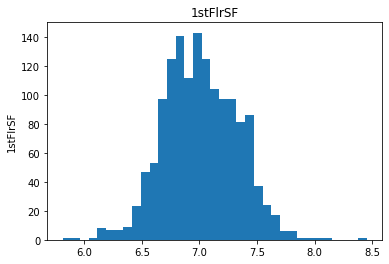

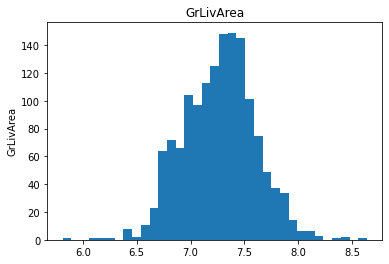

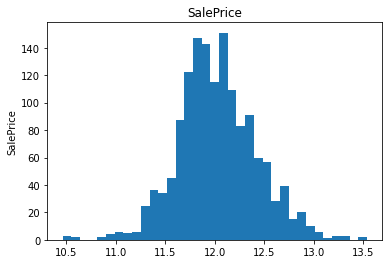

In [18]:
# Distribution after log transform
vizdata2=house_df.copy()
for x in numerical_features_cont:
    if 0 in vizdata2[x].unique():
        pass
    else:
        vizdata2[x] = np.log(vizdata2[x])
        vizdata2[x].plot.hist(bins = 35)
        plt.ylabel(x)
        plt.title(x)
        plt.show()

We have explored and visualized the training data as well as explored the features and their distributions independently.
We now move on to the Feature Engineering part where we'll handle missing values, log transformations and categorical variables.

   #### Feature Engineering

In [19]:
# Missing values in numerical features

for x in numerical_features:
    print(x,house_df[x].isnull().sum())

Id 0
MSSubClass 0
LotFrontage 259
LotArea 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
MasVnrArea 8
BsmtFinSF1 0
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
TotRmsAbvGrd 0
Fireplaces 0
GarageYrBlt 81
GarageCars 0
GarageArea 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
MiscVal 0
MoSold 0
YrSold 0
SalePrice 0


In [20]:
# Let's get the numerical features with missing variables in a list
num_missing = [x for x in numerical_features if house_df[x].isnull().sum()>0]
num_missing

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [21]:
# Let's impute the missing numerical features with median
for x in num_missing:
    house_df[x] = house_df[x].fillna(house_df[x].median())

In [22]:
# Checking if imputation worked
for x in num_missing:
    print(x,house_df[x].isnull().sum())

LotFrontage 0
MasVnrArea 0
GarageYrBlt 0


In [23]:
# Finding all categorical features with missing values
cat_miss = [x for x in categorical_features if house_df[x].isnull().sum()>0 ]
cat_miss

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [24]:
# Checking frequency of nan values in categorical features
for x in cat_miss:
    print(x,house_df[x].isnull().sum())


Alley 1369
MasVnrType 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


Let's drop 'Alley','PoolQC','Fence', and 'MiscFeature' as they have more than 85% of total values missing

In [25]:
# Dropping the above columns

house_df = house_df.drop(columns =['Alley','PoolQC','Fence','MiscFeature'],axis = 1)

In [26]:
# Updating categorical_features and cat_miss
categorical_features = [x for x in house_df.columns if house_df[x].dtypes == 'O']
cat_miss = [x for x in categorical_features if house_df[x].isnull().sum()>0 ]
cat_miss

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [27]:
# Imputing all remanining missing categorical features with most frequent value (mode)

for x in cat_miss:
    house_df[x] = house_df[x].fillna(house_df[x].dropna().mode().iloc[0])  #iloc[0] needed to get the value without index

In [28]:
# Checking for successful imputation of categorical features
for x in cat_miss:
    print(x,house_df[x].isnull().sum())

MasVnrType 0
BsmtQual 0
BsmtCond 0
BsmtExposure 0
BsmtFinType1 0
BsmtFinType2 0
Electrical 0
FireplaceQu 0
GarageType 0
GarageFinish 0
GarageQual 0
GarageCond 0


In [29]:
# Drop the 'Id' column

house_df = house_df.drop(columns =['Id'],axis = 1)

In [30]:
# Converting temporal features into age

for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
       
    house_df[feature]=house_df['YrSold']-house_df[feature]

In [31]:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,5,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Gd,Attchd,5.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,31,31,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,31.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,7,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,7.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,91,36,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,8.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,8,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,8.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [32]:
# Only remaining temporal feature is YrSold. Let's map it to ascending labels:

house_df['YrSold'] = house_df['YrSold'].map({2006: 0, 2007: 1, 2008:2,2009:3,2010:4})

In [33]:
# Updating the numerical features
numerical_features = [x for x in house_df.columns if house_df[x].dtypes != 'O']
numerical_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [34]:
# Transforming skewed data with log normal transformation

num_features=['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']

for x in num_features:
    house_df[x]=np.log(house_df[x])

In [35]:
# Label Encoding all other categorical features:

for x in categorical_features:
    labels_ordered=house_df.groupby([x])['SalePrice'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}
    house_df[x]=house_df[x].map(labels_ordered)
    

In [36]:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,4.174387,9.041922,1,0,1,1,0,0,15,3,4,3,6,7,5,5,5,1,2,12,13,2,196.0,2,3,5,2,2,0,5,706,3,0,150,856,5,4,1,4,6.752270,854,0,7.444249,1,0,2,1,3,1,2,8,6,0,1,4,5.0,1,2,548,2,3,2,0,61,0,0,0,0,0,2,2,4,4,12.247694
1,20,3,4.382027,9.169518,1,0,1,1,2,0,20,1,4,3,4,6,8,31,31,1,2,6,6,1,0.0,1,3,2,2,2,3,4,978,3,0,284,1262,5,4,1,4,7.140453,0,0,7.140453,0,1,2,0,3,1,1,6,6,1,3,4,31.0,1,2,460,2,3,2,298,0,0,0,0,0,0,5,1,4,4,12.109011
2,60,3,4.219508,9.328123,1,1,1,1,0,0,15,3,4,3,6,7,5,7,6,1,2,12,13,2,162.0,2,3,5,2,2,1,5,486,3,0,434,920,5,4,1,4,6.824374,866,0,7.487734,1,0,2,1,3,1,2,6,6,1,3,4,7.0,1,2,608,2,3,2,0,42,0,0,0,0,0,9,2,4,4,12.317167
3,70,3,4.094345,9.164296,1,1,1,1,1,0,17,3,4,3,6,7,5,91,36,1,2,4,7,1,0.0,1,3,1,1,3,0,4,216,3,0,540,756,5,3,1,4,6.867974,756,0,7.448334,1,0,1,0,3,1,2,7,6,1,1,1,8.0,0,3,642,2,3,2,0,35,272,0,0,0,0,2,0,4,1,11.849398
4,60,3,4.430817,9.565214,1,1,1,1,2,0,24,3,4,3,6,8,5,8,8,1,2,12,13,2,350.0,2,3,5,2,2,2,5,655,3,0,490,1145,5,4,1,4,7.043160,1053,0,7.695303,1,0,2,1,4,1,2,9,6,1,3,4,8.0,1,3,836,2,3,2,192,84,0,0,0,0,0,12,2,4,4,12.429216


In [60]:
# Splitting the dataset into matrix of independent features and dependent variable

X = house_df.iloc[:,:-1]
y = house_df.iloc[:,-1]

In [61]:
# Splitting into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

In [62]:
# Feature scaling
# taking feature names in a list for reconverting back to a dataframe after scaling
feature_names_train = [x for x in X_train.columns]
feature_names_test = [x for x in X_test.columns]

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Converting back to a dataframe
X_train = pd.DataFrame(data = X_train, columns = feature_names_train)
X_test = pd.DataFrame(data = X_test, columns = feature_names_test)

#### Feature Selection with Lasso Regression

In [64]:
# Importing Lasso and SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [65]:
# Instantiating the Lasso and fitting it
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0))
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [66]:
# Checking the array of selected and rejected features
feature_sel_model.get_support()

array([ True,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
        True,  True, False,  True, False,  True, False, False, False,
        True, False,  True,  True, False,  True, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False,  True,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [67]:
# let's print the number of total and selected features

# Making a list of the selected features
selected_feat = X_train.columns[(feature_sel_model.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 75
selected features: 22


In [68]:
# Modifying our training and test sets

X_train  = X_train[selected_feat]
X_test = X_test[selected_feat]

#### Modeling

We'll model the following:
1. Linear Regression
2. Decision Tree
3. Random Forest
4. SVR
5. XGBoost

Then we'll choose the best model and tune it for maximum accuracy

##### 1. Linear Regression

In [71]:
# Fitting the model
from sklearn.linear_model import LinearRegression
LinearRegressor = LinearRegression()
LinearRegressor.fit(X_train, y_train)

LinearRegression()

In [72]:
# Predicting Results
from sklearn.metrics import r2_score
y_pred = LinearRegressor.predict(X_test)
Linear_Regression_Score = r2_score(y_test, y_pred)
Linear_Regression_Score

0.8122482132966276

In [102]:
# RMSE
RMSE_LR = mean_squared_error(y_test, y_pred, squared = False)
RMSE_LR

0.16859890515860387

##### 2. Decision Tree 

In [74]:
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor()
DTR.fit(X_train,y_train)

DecisionTreeRegressor()

In [75]:
# Predicting Results
y_pred_DTR = DTR.predict(X_test)
DT_Score = r2_score(y_test, y_pred_DTR)
DT_Score

0.7517157045827949

In [101]:
# RMSE
RMSE_DT = mean_squared_error(y_test, y_pred_DTR, squared = False)
RMSE_DT

0.193881930743711

##### 3. Random Forest

In [77]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()
RFR.fit(X_train,y_train)

RandomForestRegressor()

In [79]:
# Predicting Results
y_pred_RFR = RFR.predict(X_test)
RFR_Score = r2_score(y_test, y_pred_RFR)
RFR_Score

0.8863995411775761

In [100]:
# RMSE
RMSE_RFR = mean_squared_error(y_test, y_pred_RFR, squared = False)
RMSE_RFR

0.13114530683130488

##### 4. SVR

In [80]:
from sklearn.svm import SVR
SVReg = SVR(kernel = 'rbf')
SVReg.fit(X_train, y_train)

SVR()

In [81]:
# Predicting Results
y_pred_SVR = SVReg.predict(X_test)
SVR_Score = r2_score(y_test, y_pred_SVR)
SVR_Score

0.891333990499911

In [99]:
# RMSE
RMSE_SVR = mean_squared_error(y_test, y_pred_SVR, squared = False)
RMSE_SVR

0.12826541488913432

##### 5. XGBoost

In [95]:
import xgboost as xgb
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [96]:
# Predicting Results
y_pred_XGB = xgbr.predict(X_test)
XGB_Score = r2_score(y_test, y_pred_XGB)
XGB_Score

0.874318021707507

In [98]:
# RMSE
from sklearn.metrics import mean_squared_error
RMSE_xgb = mean_squared_error(y_test, y_pred_XGB, squared = False)
RMSE_xgb

0.13794285643478102

##### Hyperparameter Tuning with RandomSearchCV

In [113]:
# Here we'll use a pipeline to efficiently apply RCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV
    
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass
        
# Create a pipeline
pipe = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator
    
# Candidate learning algorithms and their hyperparameters
search_space = [{'clf': [SVR()], # Actual Estimator
                     'clf__kernel': ['rbf', 'sigmoid'],
                     'clf__gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
                
                },
                    
                    {'clf': [xgb.XGBRegressor()],  # Actual Estimator
                     'clf__eta': [0.1, 0.2, 0.3, 0.4,0.6],
                     'clf__max_depth': [6,8,10,20,40]
                    }]
    
    
# Create Random search 
rndmsearch = RandomizedSearchCV(pipe, search_space, n_jobs = -1)
rndmsearch.fit(X_train, y_train)
ht_params = rndmsearch.best_params_
ht_score = rndmsearch.best_score_

In [114]:
ht_params

{'clf__max_depth': 10,
 'clf__eta': 0.1,
 'clf': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eta=0.1, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)}

In [115]:
ht_score

0.8982781389616351

In [117]:
# Fitting tuned model
xgbr_tuned = xgb.XGBRegressor(max_depth = 10, eta = 0.1)
xgbr_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
# Predicting with tuned model
y_pred_XGB_tuned = xgbr_tuned.predict(X_test)
XGB_tuned_Score = r2_score(y_test, y_pred_XGB_tuned)
XGB_tuned_Score

0.8789859312026234